<a href="https://colab.research.google.com/github/sunnywithcurlyhair/DS_Project_4/blob/main/dog_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This project uses neural networks transfer learning in tensorflow to build an image classifier for emotions of dogs. The dataset is from [Kaggle](https://www.kaggle.com/datasets/danielshanbalico/dog-emotion) which contains 4000 images in total, 1000 in each of the 4 classes - angry, happy, relaxed, sad.


This notebook should be run in Google Colab using GPU, the dataset is directly loaded from Kaggle API - a Kaggle token username and password is needed.

## Model strategy


*   InceptionV3 and VGG16 were both explored as pre-trained feature extracters.

*   Global Average Pooling was utilized to reduce dimensions prior to the dense layers.

*   Data augmentation and Dropouts were utilized to regularize.
*   Model checkpoints were also used to save the best model accross different epochs which can be used to import and train further.





In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Resizing, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import datasets
from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import os
from PIL import Image

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/danielshanbalico/dog-emotion")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sunnywithcurlyhair
Your Kaggle Key: ··········


100%|██████████| 155M/155M [00:10<00:00, 16.1MB/s]


In [ ]:
os.chdir('./dog-emotion')
os.rename('Dog Emotion', 'Dog_Emotion')
os.chdir('./Dog_Emotion')
os.remove('labels.csv')
os.chdir('../')
os.mkdir('Dog_Emotion_Cleaned')
os.chdir('./Dog_Emotion_Cleaned')
os.mkdir('angry')
os.mkdir('happy')
os.mkdir('relaxed')
os.mkdir('sad')
os.chdir('../../')

In [ ]:
# checking if any of the images were corrupted
data_dir='./dog-emotion/Dog_Emotion'
bad_img_list=[]
total=0
good=0
bad=0
classes=sorted(os.listdir(data_dir))
for klass in classes:
    good_class=0
    bad_class=0
    total_class=0
    msg=f'processing class {klass}'
    print(msg, '\r', end= '')
    classpath=os.path.join(data_dir, klass)
    flist=sorted(os.listdir(classpath))
    for f in flist:
        total +=1
        total_class +=1
        fpath=os.path.join(classpath,f)
        try:
            img= Image.open(fpath)
            array=np.asarray(img)
            good +=1
            good_class +=1
        except:
            bad_img_list.append(fpath)
            bad +=1
            bad_class +=1

    msg=f'class {klass} contains {total_class} files, {good_class} are valid image files and {bad_class} defective image files'
    print (msg)
msg=f'the dataset contains {total} image files, {good} are valid image files and {bad} are defective image files'
print (msg)
if bad>0:
    ans=input('to print a list of defective image files enter P, to not print press Enter')
    if ans == 'P' or ans == 'p':
        for f in bad_img_list:
            print (f)

class angry contains 1000 files, 1000 are valid image files and 0 defective image files
class happy contains 1000 files, 1000 are valid image files and 0 defective image files
class relaxed contains 1000 files, 1000 are valid image files and 0 defective image files
class sad contains 1000 files, 1000 are valid image files and 0 defective image files
the dataset contains 4000 image files, 4000 are valid image files and 0 are defective image files


In [ ]:
# we have a mix of jpg and jpeg, which caused an error when we fit the model downstream, converting all images to jpeg here
data_dir='./dog-emotion/Dog_Emotion'
data_dir_to_save='./dog-emotion/Dog_Emotion_Cleaned'

total=0
good=0
bad=0
classes=sorted(os.listdir(data_dir))
for klass in classes:
    total_class=0
    msg=f'processing class {klass}'
    print(msg, '\r', end= '')
    classpath=os.path.join(data_dir, klass)
    classpath_to_save=os.path.join(data_dir_to_save,klass)
    flist=sorted(os.listdir(classpath))
    for f in flist:
        total +=1
        total_class +=1
        fpath=os.path.join(classpath,f)
        img= Image.open(fpath)
        img.save(os.path.join(classpath_to_save,(str(total))+'.jpeg'))

In [ ]:
train=image_dataset_from_directory(
    "dog-emotion/Dog_Emotion_Cleaned",
    image_size=(128,128),
    batch_size=32,
    seed=42,
    validation_split=0.2,
    subset="training")

Found 4000 files belonging to 4 classes.
Using 3200 files for training.


In [ ]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test=image_dataset_from_directory(
    "dog-emotion/Dog_Emotion_Cleaned",
    image_size=(128,128),
    batch_size=32,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [ ]:
test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### InceptionV3
First iteration using InceptionV3, 128x128 input shape

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(128,128,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalizati

In [ ]:
base_model.trainable=False

In [ ]:
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 batch_normalization_94 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 21868612 (83.42 MB)
Trainable params: 6576

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train,epochs=50,batch_size=32,validation_data=test)

Epoch 1/50
100/100 [==============================] - 18s 67ms/step - loss: 1.4242 - accuracy: 0.3075 - val_loss: 1.4367 - val_accuracy: 0.2988
Epoch 2/50
100/100 [==============================] - 6s 62ms/step - loss: 1.3445 - accuracy: 0.3462 - val_loss: 1.3642 - val_accuracy: 0.3275
Epoch 3/50
100/100 [==============================] - 5s 47ms/step - loss: 1.3147 - accuracy: 0.3806 - val_loss: 1.3571 - val_accuracy: 0.3300
Epoch 4/50
100/100 [==============================] - 6s 57ms/step - loss: 1.2944 - accuracy: 0.3959 - val_loss: 1.3578 - val_accuracy: 0.3400
Epoch 5/50
100/100 [==============================] - 5s 46ms/step - loss: 1.2759 - accuracy: 0.4103 - val_loss: 1.3511 - val_accuracy: 0.3525
Epoch 6/50
100/100 [==============================] - 6s 57ms/step - loss: 1.2506 - accuracy: 0.4381 - val_loss: 1.3884 - val_accuracy: 0.3187
Epoch 7/50
100/100 [==============================] - 7s 64ms/step - loss: 1.2274 - accuracy: 0.4428 - val_loss: 1.4302 - val_accuracy: 0.336

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

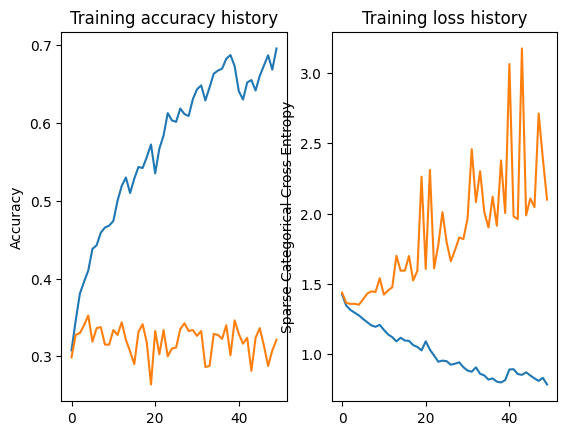

In [ ]:
f,ax=plt.subplots(1,2)
model_history=pd.DataFrame(history.history)
model_history.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(model_history[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(model_history[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

There is a clear issue with the unstable model, inception v3 has too many layers with 128x128 input, changing the input size to 224x224 to see if it performs better

In [ ]:
train=image_dataset_from_directory(
    "dog-emotion/Dog_Emotion_Cleaned",
    image_size=(224,224),
    batch_size=32,
    seed=42,
    validation_split=0.2,
    subset="training")
test=image_dataset_from_directory(
    "dog-emotion/Dog_Emotion_Cleaned",
    image_size=(224,224),
    batch_size=32,
    seed=42,
    validation_split=0.2,
    subset="validation")

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [ ]:
base_model_224 = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
base_model_224.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [ ]:
base_model_224.trainable=False

In [ ]:
model1=Sequential()
model1.add(base_model_224)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(32,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(4,activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 batch_normalization_189 (B  (None, 32)                128       
 atchNormalization)                                              
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 21868612 (83.42 MB)
Trainable params: 65

In [ ]:
model1.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model1_history=model1.fit(train,epochs=50,batch_size=32,validation_data=test)

Epoch 1/50
100/100 [==============================] - 19s 109ms/step - loss: 1.4029 - accuracy: 0.3016 - val_loss: 1.6214 - val_accuracy: 0.3013
Epoch 2/50
100/100 [==============================] - 10s 95ms/step - loss: 1.3183 - accuracy: 0.3700 - val_loss: 1.3804 - val_accuracy: 0.3438
Epoch 3/50
100/100 [==============================] - 10s 97ms/step - loss: 1.2895 - accuracy: 0.3972 - val_loss: 1.3551 - val_accuracy: 0.3587
Epoch 4/50
100/100 [==============================] - 9s 90ms/step - loss: 1.2659 - accuracy: 0.4184 - val_loss: 1.4288 - val_accuracy: 0.3000
Epoch 5/50
100/100 [==============================] - 10s 96ms/step - loss: 1.2526 - accuracy: 0.4297 - val_loss: 1.3855 - val_accuracy: 0.3438
Epoch 6/50
100/100 [==============================] - 10s 95ms/step - loss: 1.2331 - accuracy: 0.4341 - val_loss: 1.3999 - val_accuracy: 0.3338
Epoch 7/50
100/100 [==============================] - 10s 94ms/step - loss: 1.2210 - accuracy: 0.4456 - val_loss: 1.3386 - val_accuracy:

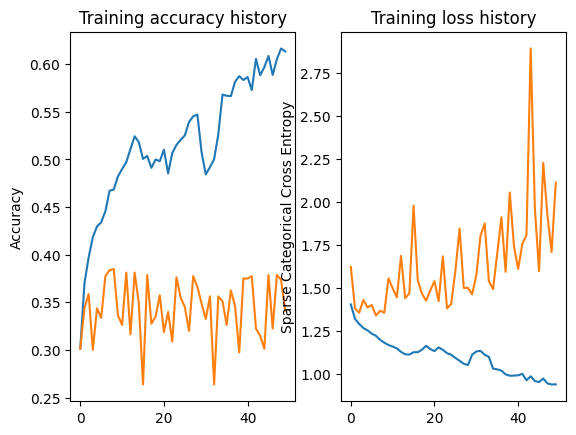

In [ ]:
f,ax=plt.subplots(1,2)
model1_history=pd.DataFrame(model1_history.history)
model1_history.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(model1_history[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(model1_history[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

it's slightly more stable, will stick with 224*224 for now.

Will add dropout regularization next since the CNN feature extraction after global average pooling still have a high amount of nodes (2048)

In [ ]:
model2=Sequential()
model2.add(base_model_224)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(32,activation='relu'))
model2.add(Dropout(0.1))
model2.add(BatchNormalization())
model2.add(Dense(4,activation='softmax'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [ ]:
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model2_history=model2.fit(train,epochs=50,batch_size=32,validation_data=test)

Epoch 1/50
100/100 [==============================] - 41s 110ms/step - loss: 1.6346 - accuracy: 0.2837 - val_loss: 1.4598 - val_accuracy: 0.3200
Epoch 2/50
100/100 [==============================] - 10s 95ms/step - loss: 1.4375 - accuracy: 0.3178 - val_loss: 1.3593 - val_accuracy: 0.3413
Epoch 3/50
100/100 [==============================] - 9s 89ms/step - loss: 1.3810 - accuracy: 0.3603 - val_loss: 1.3447 - val_accuracy: 0.3400
Epoch 4/50
100/100 [==============================] - 10s 94ms/step - loss: 1.3370 - accuracy: 0.3666 - val_loss: 1.3336 - val_accuracy: 0.3713
Epoch 5/50
100/100 [==============================] - 10s 99ms/step - loss: 1.3153 - accuracy: 0.3925 - val_loss: 1.3299 - val_accuracy: 0.3550
Epoch 6/50
100/100 [==============================] - 10s 96ms/step - loss: 1.3024 - accuracy: 0.4009 - val_loss: 1.3290 - val_accuracy: 0.3600
Epoch 7/50
100/100 [==============================] - 10s 96ms/step - loss: 1.2924 - accuracy: 0.3984 - val_loss: 1.3236 - val_accuracy:

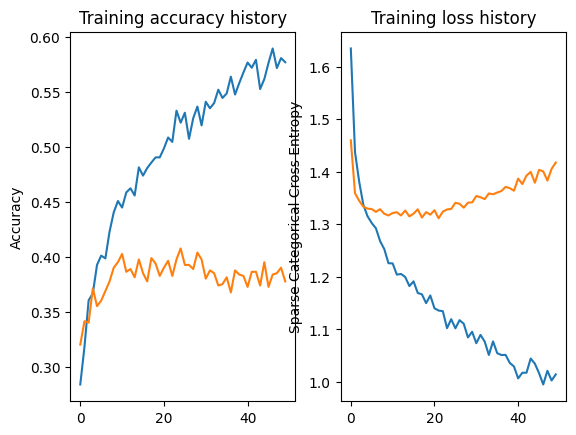

In [ ]:
f,ax=plt.subplots(1,2)
model2_history=pd.DataFrame(model2_history.history)
model2_history.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(model2_history[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(model2_history[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

Still clearly overfitting and the fluctuatons is rather large, though the validation curves are smoother, will try data augmentation with the previous model next to try to improve.

In [ ]:
#data augmentation steps
translate=RandomTranslation(0.1,0.1)
zoom=RandomZoom(0.1)
@tf.function
def augment(image):
  image=translate(image)
  image=zoom(image)
  image=tf.image.random_flip_left_right(image)
  return image


In [ ]:
# to show examples of data augmentation results
train_orig=image_dataset_from_directory(
    "dog-emotion/Dog_Emotion_Cleaned",
    image_size=(224,224),
    batch_size=32,
    seed=42,
    shuffle=False)

Found 4000 files belonging to 4 classes.


In [ ]:
train_aug=train_orig.map(lambda x, y: (augment(x), y))
train_aug

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_aug_images=np.concatenate([x for x, y in train_aug], axis=0)
train_aug_targets=np.concatenate([y for x, y in train_aug], axis=0)


In [ ]:
train_orig_images=np.concatenate([x for x, y in train_orig], axis=0)
train_orig_targets=np.concatenate([y for x, y in train_orig], axis=0)


In [ ]:
for i in [0,1000,2000,3000]:
  print(train_aug_targets[i])
  print(train_orig_targets[i])

0
0
1
1
2
2
3
3


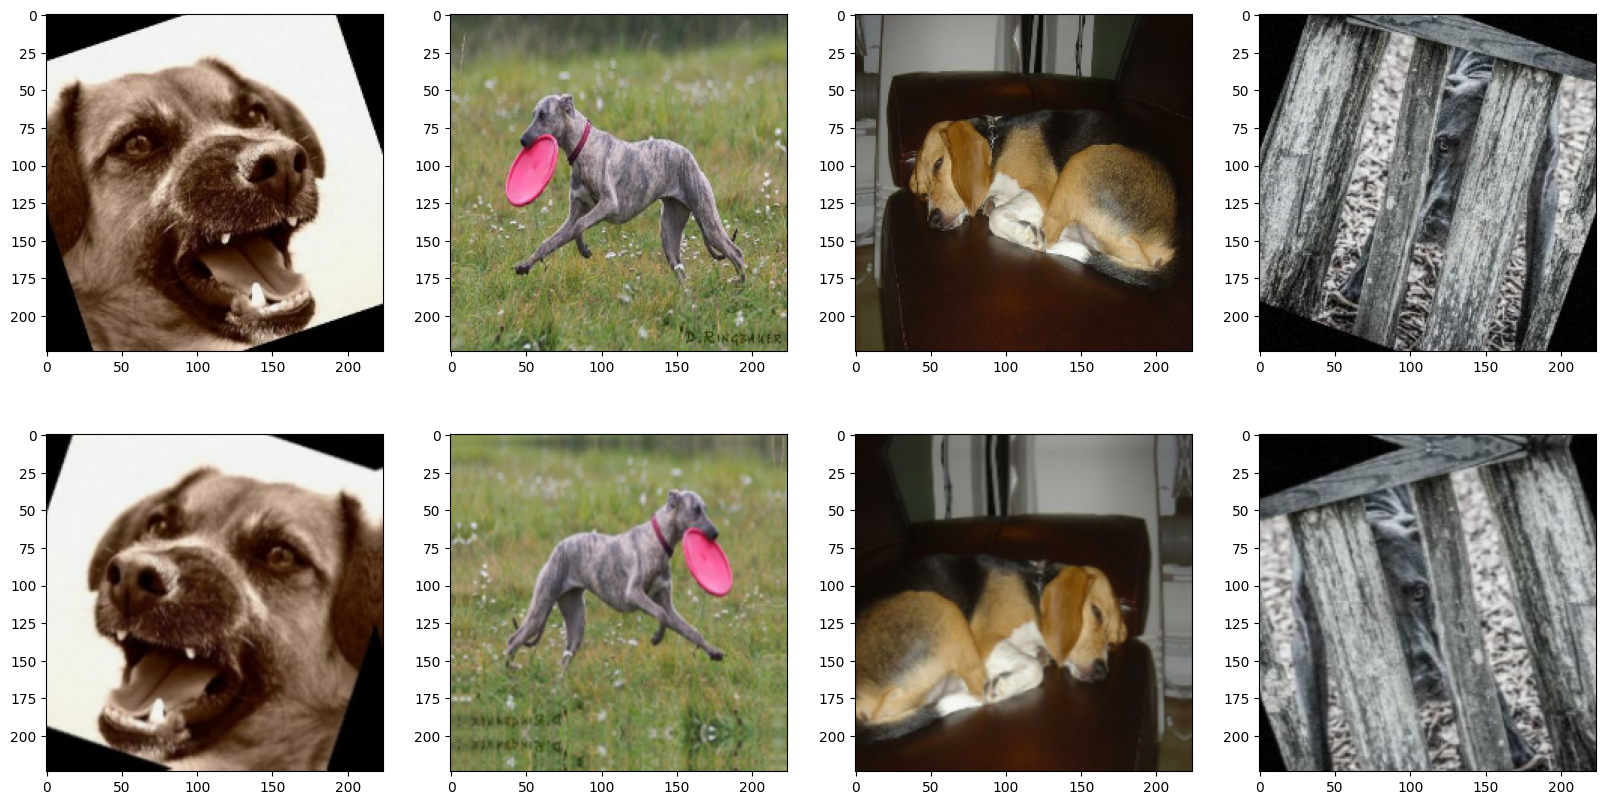

In [ ]:
f,ax=plt.subplots(2,4,figsize=(20,10))
for i,idx in enumerate([0,1005,2010,3009]):
  ax[0][i].imshow(train_orig_images[idx].astype('uint8'))
  ax[1][i].imshow(train_aug_images[idx].astype('uint8'))

In [ ]:
# data augmentation transformation on the original train set
train=train.map(lambda x, y: (augment(x), y))
train

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model2_aug_history=model2.fit(train,epochs=50,batch_size=32,validation_data=test)

Epoch 1/50
100/100 [==============================] - 43s 429ms/step - loss: 1.3886 - accuracy: 0.3884 - val_loss: 1.3649 - val_accuracy: 0.3775
Epoch 2/50
100/100 [==============================] - 40s 399ms/step - loss: 1.3460 - accuracy: 0.3831 - val_loss: 1.3224 - val_accuracy: 0.3963
Epoch 3/50
100/100 [==============================] - 38s 379ms/step - loss: 1.3183 - accuracy: 0.3909 - val_loss: 1.3060 - val_accuracy: 0.3812
Epoch 4/50
100/100 [==============================] - 40s 392ms/step - loss: 1.3152 - accuracy: 0.3850 - val_loss: 1.3038 - val_accuracy: 0.3925
Epoch 5/50
100/100 [==============================] - 40s 388ms/step - loss: 1.2892 - accuracy: 0.3925 - val_loss: 1.3007 - val_accuracy: 0.3900
Epoch 6/50
100/100 [==============================] - 39s 388ms/step - loss: 1.2915 - accuracy: 0.4091 - val_loss: 1.2982 - val_accuracy: 0.3812
Epoch 7/50
100/100 [==============================] - 40s 391ms/step - loss: 1.2851 - accuracy: 0.4000 - val_loss: 1.2947 - val_ac

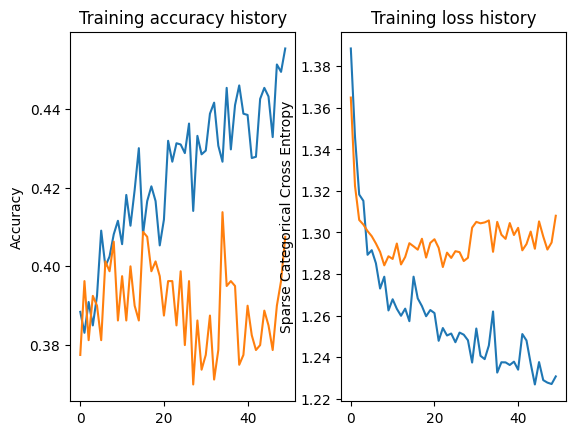

In [ ]:
f,ax=plt.subplots(1,2)
model2_aug_history=pd.DataFrame(model2_aug_history.history)
model2_aug_history.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(model2_aug_history[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(model2_aug_history[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

The model looks much more stable with less overfitting (Note that the graph above is on a different scale than the previous graphs, but there is indeed less deviation between train/validation scores). Though it still has a low score but this is the best inception v3 transfer learned model so far,  we may want to use a learning rate scheduler to potentially smooth out the optimization and checkpoint callback to save the best model.

In [ ]:
from google.colab import drive
drive.mount('/content/frozen')

Mounted at /content/frozen


In [ ]:
def schedual_lr(epoch, lr):
  if epoch < 25:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(schedual_lr)


In [ ]:
def schedual_lr0(epoch, lr):
  if epoch < 25:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback_incep = LearningRateScheduler(schedual_lr0)


In [ ]:
inceptionv3_checkpoint_path = "drive/MyDrive/Colab Notebooks/InceptionV3_frozen"

cp_callback = ModelCheckpoint(filepath=inceptionv3_checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True)

In [ ]:
model2_aug_history_callbacks=model2.fit(train,epochs=50,batch_size=32,validation_data=test,callbacks=[lr_callback_incep,cp_callback])

Epoch 1/50
100/100 [==============================] - 86s 731ms/step - loss: 1.6501 - accuracy: 0.2825 - val_loss: 1.5553 - val_accuracy: 0.2875 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 67s 673ms/step - loss: 1.4777 - accuracy: 0.3013 - val_loss: 1.3819 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 67s 671ms/step - loss: 1.3946 - accuracy: 0.3369 - val_loss: 1.3577 - val_accuracy: 0.3425 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 67s 670ms/step - loss: 1.3991 - accuracy: 0.3356 - val_loss: 1.3361 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 39s 383ms/step - loss: 1.3746 - accuracy: 0.3519 - val_loss: 1.3355 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 39s 382ms/step - loss: 1.3613 - accuracy: 0.3562 - val_loss: 1.3442 - val_accuracy: 0.3462 - lr: 0.0010
Epoch 7/50
100/100 [==============================] 

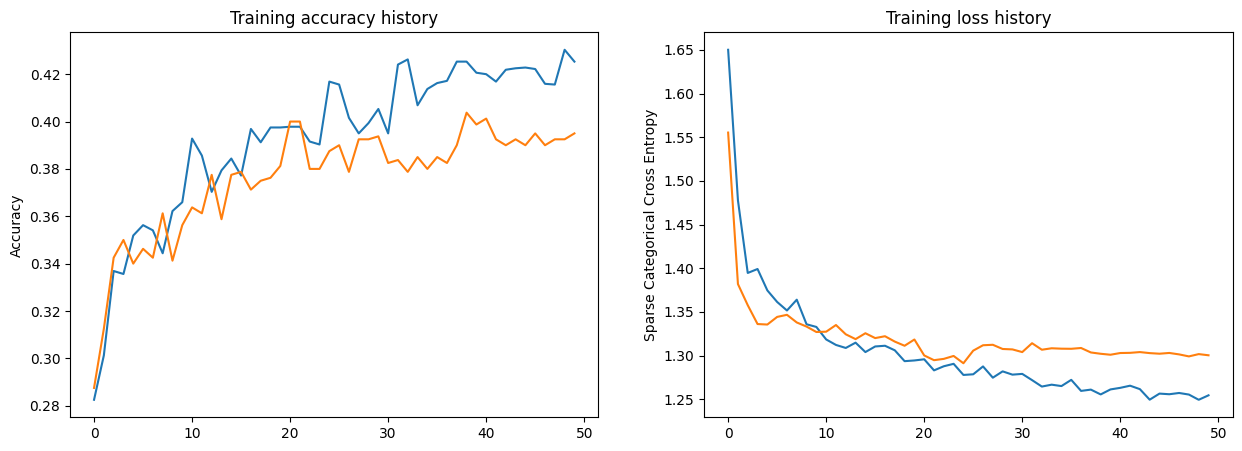

In [ ]:
f,ax=plt.subplots(1,2,figsize=(15,5))
model2_history_callbacks=pd.DataFrame(model2_aug_history_callbacks.history)
model2_history_callbacks.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(model2_history_callbacks[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(model2_history_callbacks[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

In [ ]:
inceptionv3_checkpoint_path = "drive/MyDrive/Colab Notebooks/InceptionV3_frozen"
inceptionv3_best = tf.keras.models.load_model(inceptionv3_checkpoint_path)
inceptionv3_best.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

1/1 [==============================] - 0s 63ms/step


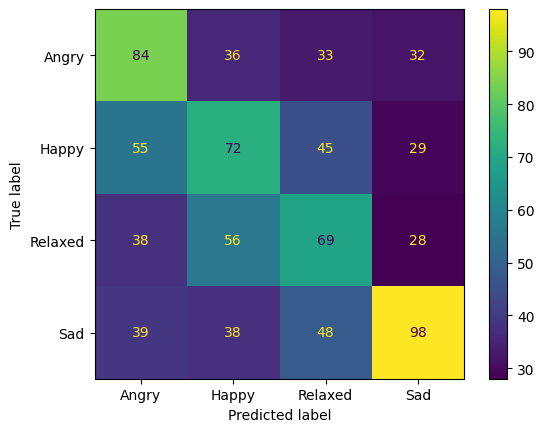

In [ ]:
inceptionv3_best.evaluate(test)
y_pred = np.array([])
y_test =  np.array([])

for x, y in test:
  y_pred = np.concatenate([y_pred,
                          np.argmax(inceptionv3_best.predict(x), axis = -1)])
  y_test = np.concatenate([y_test, (y.numpy())])

cm = confusion_matrix(y_test, y_pred)
labels=['Angry','Happy','Relaxed','Sad']
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot()
plt.show()


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.39      0.45      0.42       185
         1.0       0.36      0.36      0.36       201
         2.0       0.35      0.36      0.36       191
         3.0       0.52      0.44      0.48       223

    accuracy                           0.40       800
   macro avg       0.41      0.40      0.40       800
weighted avg       0.41      0.40      0.41       800



### VGG 16

In [ ]:
base_model1 = tf.keras.applications.vgg16.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
base_model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_model1.trainable = False

In [ ]:
model3=Sequential()
model3.add(base_model1)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(32,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(4,activation='softmax'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 32)                16416     
                                                                 
 batch_normalization_192 (B  (None, 32)                128       
 atchNormalization)                                              
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 14731364 (56.20 MB)
Trainable params: 16

In [ ]:
model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model3_history=model3.fit(train,epochs=50,batch_size=32,validation_data=test)

Epoch 1/50
100/100 [==============================] - 51s 433ms/step - loss: 1.2673 - accuracy: 0.4697 - val_loss: 1.2030 - val_accuracy: 0.5863
Epoch 2/50
100/100 [==============================] - 45s 449ms/step - loss: 0.9105 - accuracy: 0.6216 - val_loss: 0.8806 - val_accuracy: 0.6488
Epoch 3/50
100/100 [==============================] - 42s 416ms/step - loss: 0.8123 - accuracy: 0.6622 - val_loss: 0.8141 - val_accuracy: 0.6925
Epoch 4/50
100/100 [==============================] - 43s 423ms/step - loss: 0.7549 - accuracy: 0.6956 - val_loss: 0.8466 - val_accuracy: 0.6750
Epoch 5/50
100/100 [==============================] - 43s 422ms/step - loss: 0.7171 - accuracy: 0.7131 - val_loss: 0.7607 - val_accuracy: 0.6963
Epoch 6/50
100/100 [==============================] - 44s 438ms/step - loss: 0.6785 - accuracy: 0.7372 - val_loss: 0.7852 - val_accuracy: 0.7025
Epoch 7/50
100/100 [==============================] - 42s 420ms/step - loss: 0.6443 - accuracy: 0.7516 - val_loss: 0.7579 - val_ac

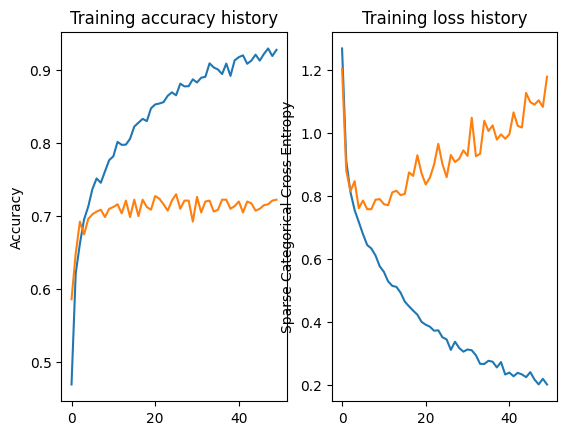

In [ ]:
f,ax=plt.subplots(1,2)
model3_aug_history=pd.DataFrame(model3_history.history)
model3_aug_history.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(model3_aug_history[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(model3_aug_history[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

Scores are much higher - need to implement dropout regularization, will save this model for best performing epoch history and use a learning rate scheduler

In [ ]:
vgg_checkpoint_path = "drive/MyDrive/Colab Notebooks/VGG_frozen"

cp_callback_vgg = ModelCheckpoint(filepath=vgg_checkpoint_path,
                                  save_weights_only=False,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=True)

In [ ]:
model4=Sequential()
model4.add(base_model1)
model4.add(GlobalAveragePooling2D())
model4.add(Dropout(0.3))
model4.add(BatchNormalization())
model4.add(Dense(32,activation='relu'))
model4.add(Dropout(0.1))
model4.add(BatchNormalization())
model4.add(Dense(4,activation='softmax'))
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_193 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 dense_8 (Dense)             (None, 32)                16416     
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [ ]:
model4.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

1. Different optimizers.
2. Different batch sizes.
3. Unfreeze frozen layers of VGG's output.

In [ ]:
model4_history_callbacks=model4.fit(train,epochs=50,batch_size=32,validation_data=test,callbacks=[lr_callback,cp_callback_vgg])

Epoch 1/50
100/100 [==============================] - 46s 451ms/step - loss: 1.2253 - accuracy: 0.4869 - val_loss: 1.0250 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 46s 453ms/step - loss: 1.0825 - accuracy: 0.5491 - val_loss: 0.9081 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 48s 479ms/step - loss: 0.9780 - accuracy: 0.5813 - val_loss: 0.8647 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 46s 456ms/step - loss: 0.9517 - accuracy: 0.6075 - val_loss: 0.8428 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 46s 460ms/step - loss: 0.9237 - accuracy: 0.6150 - val_loss: 0.8092 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 46s 459ms/step - loss: 0.9097 - accuracy: 0.6206 - val_loss: 0.8041 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 7/50
100/100 [==============================] 

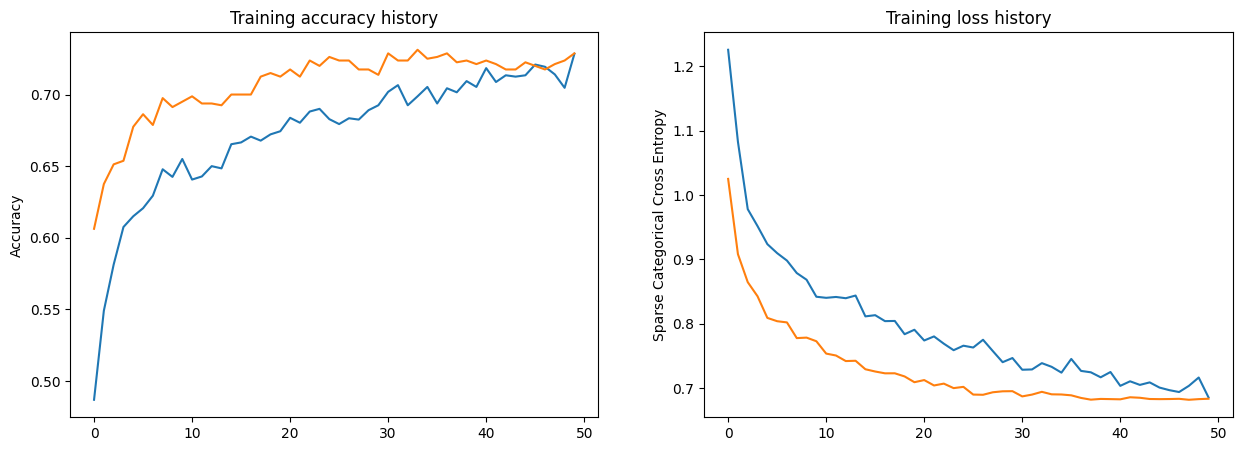

In [ ]:
f,ax=plt.subplots(1,2,figsize=(15,5))
model4_aug_history_callbacks=pd.DataFrame(model4_history_callbacks.history)
model4_aug_history_callbacks.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(model4_aug_history_callbacks[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(model4_aug_history_callbacks[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

In [ ]:
vgg_checkpoint_path = "drive/MyDrive/Colab Notebooks/VGG_frozen"
vgg_best = tf.keras.models.load_model(vgg_checkpoint_path)
vgg_best.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_193 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 dense_8 (Dense)             (None, 32)                16416     
                                                                 
 dropout_3 (Dropout)         (None, 32)               

1/1 [==============================] - 0s 28ms/step


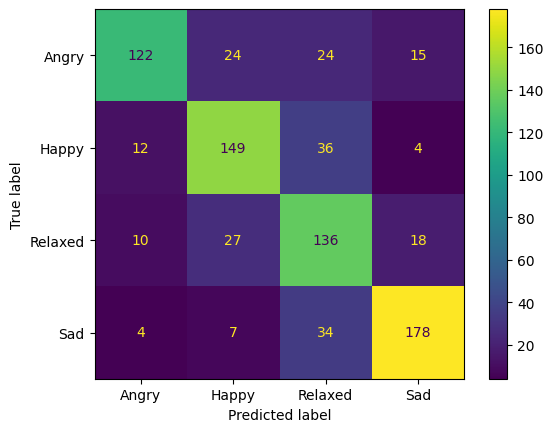

In [ ]:
vgg_best.evaluate(test)
y_pred = np.array([])
y_test =  np.array([])

for x, y in test:
  y_pred = np.concatenate([y_pred,
                          np.argmax(vgg_best.predict(x), axis = -1)])
  y_test = np.concatenate([y_test, (y.numpy())])

cm = confusion_matrix(y_test, y_pred)
labels=['Angry','Happy','Relaxed','Sad']
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot()
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.66      0.73       185
         1.0       0.72      0.74      0.73       201
         2.0       0.59      0.71      0.65       191
         3.0       0.83      0.80      0.81       223

    accuracy                           0.73       800
   macro avg       0.74      0.73      0.73       800
weighted avg       0.74      0.73      0.73       800



we are performing at 73% accuracy rate which is significantly better, train and validation learning curves also look more ideal. From the confusion matrix and classification metrics, we can see the model is not classifying the 'happy' and 'relax' classes as accurately as 'angry' or 'sad' classes, which are represented by more distint features in a dog's face (e.g. widely opened mouths and exposed sharp teeth). We will try to improve accuracy score by fine tuning a couple of the last layer within the feature extraction layers.

In [ ]:
vgg_best.layers[0].layers

In [ ]:
[layer.trainable for layer in vgg_best.layers[0].layers]

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [ ]:
vgg_best.layers[0].layers[-2:]

In [ ]:
# unfreeze the last two layers in best model saved for vgg16
for layer in vgg_best.layers[0].layers[-2:]:
  layer.trainable=True
print([layer.trainable for layer in vgg_best.layers[0].layers])

[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True]


In [ ]:
vgg_best.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_193 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 dense_8 (Dense)             (None, 32)                16416     
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [ ]:
from tensorflow.keras.optimizers import Adam
adam_ft = Adam(learning_rate = 1e-4)
vgg_best.compile(optimizer=adam_ft,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
vgg_ft_checkpoint_path = "drive/MyDrive/Colab Notebooks/VGG_ft"
vgg_ft_checkpoint = ModelCheckpoint(filepath=vgg_ft_checkpoint_path,save_weights_only=False,monitor='val_accuracy',mode='max',save_best_only=True)

In [ ]:
vgg_ft_history_callbacks=vgg_best.fit(train,epochs=50,batch_size=32,validation_data=test,callbacks=[vgg_ft_checkpoint])

Epoch 1/50
100/100 [==============================] - 29s 186ms/step - loss: 0.6965 - accuracy: 0.7128 - val_loss: 0.6907 - val_accuracy: 0.7212
Epoch 2/50
100/100 [==============================] - 16s 160ms/step - loss: 0.6943 - accuracy: 0.7169 - val_loss: 0.6901 - val_accuracy: 0.7163
Epoch 3/50
100/100 [==============================] - 16s 161ms/step - loss: 0.6902 - accuracy: 0.7206 - val_loss: 0.6893 - val_accuracy: 0.7163
Epoch 4/50
100/100 [==============================] - 18s 178ms/step - loss: 0.6823 - accuracy: 0.7241 - val_loss: 0.6881 - val_accuracy: 0.7188
Epoch 5/50
100/100 [==============================] - 16s 157ms/step - loss: 0.6629 - accuracy: 0.7303 - val_loss: 0.6878 - val_accuracy: 0.7138
Epoch 6/50
100/100 [==============================] - 16s 158ms/step - loss: 0.6701 - accuracy: 0.7234 - val_loss: 0.6871 - val_accuracy: 0.7188
Epoch 7/50
100/100 [==============================] - 16s 160ms/step - loss: 0.6890 - accuracy: 0.7216 - val_loss: 0.6859 - val_ac

In [ ]:
vgg_ft_model=tf.keras.models.load_model(vgg_ft_checkpoint_path)
vgg_ft_model.evaluate(test)

25/25 [==============================] - 5s 129ms/step - loss: 0.6813 - accuracy: 0.7275


[0.6813013553619385, 0.7275000214576721]

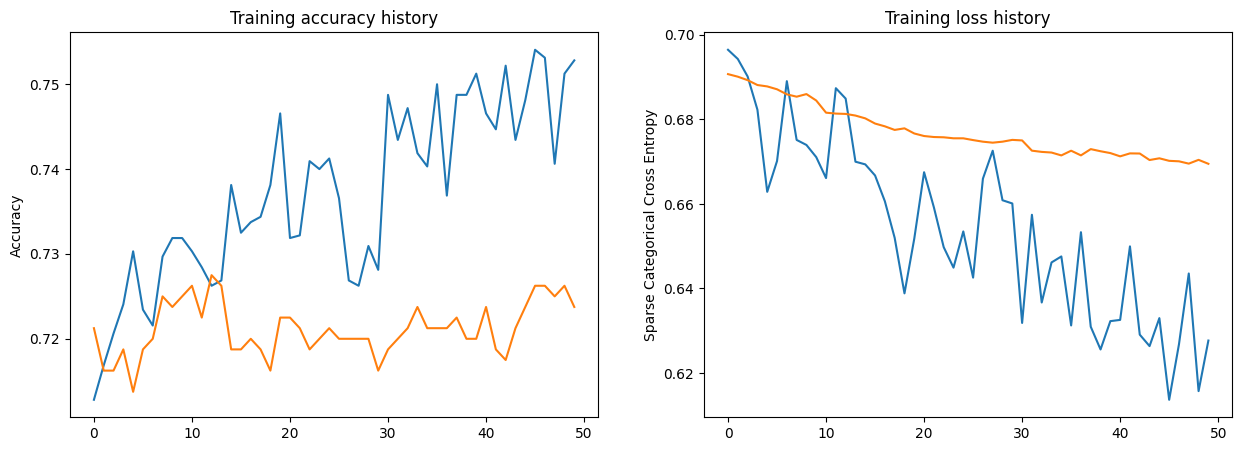

In [ ]:
f,ax=plt.subplots(1,2,figsize=(15,5))
vgg_ft_history=pd.DataFrame(vgg_ft_history_callbacks.history)
vgg_ft_history.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(vgg_ft_history[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(vgg_ft_history[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

Unfreezing the last two layers in VGG16 and fine tune did not significantly improve the model, our best model so far is still the previous VGG16 model saved

### Conclusion and next steps



*   VGG 16 works better than Inception V3 in this particular case. A less complex model as features extractor is better as important features are concentrated in a dog’s face instead of the full image
*   Next we can try visualizing feature extractions in the convolutional layers to tune further

